In [13]:
import numpy as np
import skimage.draw as draw

In [14]:
def my_imfilter(image,filter):
     
    if filter.shape[0] % 2 == 0 or filter.shape[1] % 2 == 0:
        return
    
    filter_size = filter.shape
    ##Create pad image
    pad_size = [int(np.floor(x/2)) for x in filter_size]
    filtered_image = np.empty(image.shape)
    pad_image = np.lib.pad(image, ((pad_size[0],),(pad_size[1],),(0,)), 'symmetric')


    if(image.shape[2] == 1):
        for i in range(0, filtered_image.shape[0]):
            for j in range(0, filtered_image.shape[1]):
                window = pad_image[i:i+filter_size[0], j:j+filter_size[1]]
                filtered_image[i][j] = np.sum(np.multiply(window, filter))

        return filtered_image

    else:
        filter = filter.reshape((filter_size[0],filter_size[1],1))
        for i in range(0, filtered_image.shape[0]):
            for j in range(0, filtered_image.shape[1]):
                window = pad_image[i:i+filter_size[0], j:j+filter_size[1],:]
                filtered_image[i:i+1, j:j+1, :]= np.sum(np.multiply(window, filter), axis=(0,1))
        return filtered_image


In [15]:
def create_hybrid_image(image1, image2, filter):
    assert image1.shape[0] == image2.shape[0]    
    assert image1.shape[1] == image2.shape[1]
    assert image1.shape[2] == image2.shape[2]


    low_frequencies = my_imfilter(image1, filter)
    high_frequencies = image2 - my_imfilter(image2, filter)
    img = low_frequencies + high_frequencies
    hybrid_image = np.clip(img,0,1)

    return low_frequencies, high_frequencies,hybrid_image


In [16]:

def combine(image1, image2):
    assert image1.shape[0] == image2.shape[0]    
    assert image1.shape[1] == image2.shape[1]
    assert image1.shape[2] == image2.shape[2]
    
    for i in range(0, image1.shape[0]):
        image1[:, :, i] = np.fft.fftshift(np.fft.fft2(image1[:, :, i]))
        image2[:, :, i] = np.fft.fftshift(np.fft.fft2(image2[:, :, i]))
        
    d1h, d1s = draw.draw.disk((image1.shape[0], image1.shape[1]), 12)
    d2h, d2s = draw.draw.disk((image2.shape[0], image2.shape[1]), 8)
    
    disk1 = getGausian(image1.shape[0], image1.shape[1],12)
    disk2 = getGausian(image2.shape[0], image2.shape[1],9)
    
    #disk1[d1h, d1s] = 1
    #disk2[d2h, d2s] = 1
    disk2 = 1 - disk2
     
    
    for i in range(0, image1.shape[0]):
        image1[:, :, i] = image1[:, :, i] * disk1
        image2[:, :, i] = image2[:, :, i] * disk2

        
    for i in range(0, image1.shape[0]):
        image1[:, :, i] = np.fft.ifft2(np.fft.ifftshift(image1[:, :, i]))
        image2[:, :, i] = np.fft.ifft2(np.fft.ifftshift(image2[:, :, i]))

    return image1 + image2
    
    

In [17]:
def getGausian(x, y, sig=1):
    
    assert y % 2 == 1
    assert x % 2 == 1
    
    xs = np.linspace(-(x-1)/2, (x-1)/2, x)
    ys = np.linspace(-(y-1)/2, (y-1)/2, y)
    
    gausX = 1 / np.sqrt(2*np.pi*sig) *np.exp(-(xs**2)/(2*sig**2))
    gausY = 1 / np.sqrt(2*np.pi*sig) *np.exp(-(ys**2)/(2*sig**2))
    
    myGausian = np.outer(gausX, gausY)
    
    return myGausian / np.max(myGausian)
    

In [18]:
print(getGausian(7, 7, 2))

[[0.10539922 0.19691168 0.2865048  0.32465247 0.2865048  0.19691168
  0.10539922]
 [0.19691168 0.36787944 0.53526143 0.60653066 0.53526143 0.36787944
  0.19691168]
 [0.2865048  0.53526143 0.77880078 0.8824969  0.77880078 0.53526143
  0.2865048 ]
 [0.32465247 0.60653066 0.8824969  1.         0.8824969  0.60653066
  0.32465247]
 [0.2865048  0.53526143 0.77880078 0.8824969  0.77880078 0.53526143
  0.2865048 ]
 [0.19691168 0.36787944 0.53526143 0.60653066 0.53526143 0.36787944
  0.19691168]
 [0.10539922 0.19691168 0.2865048  0.32465247 0.2865048  0.19691168
  0.10539922]]


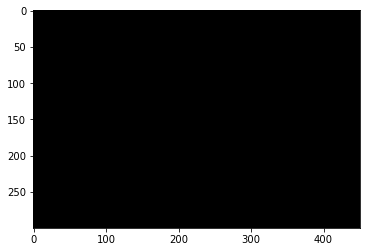

In [13]:
import matplotlib.pyplot as plt
import skimage.data as data
plt.imshow(my_imfilter(data.chelsea().astype(np.float32), getGausian(3, 3, 1)) / 255)
plt.show()